```
LSTM vs LLaMA vs Mamba
```

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

## Hyperparameters and Configuration

In [2]:
# Modified hyperparameters
SEQUENCE_LENGTH = 64

EMBEDDING_DIM = 64
HIDDEN_DIM = EMBEDDING_DIM*2

BATCH_SIZE = 512
EPOCHS = 10
LEARNING_RATE = 1e-4
VALIDATION_SPLIT = 0.1

NUM_LAYERS = 4
NUM_HEADS = 4
FFN_DIM = 480
DROPOUT = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Preparation

We are using the TinyShakespeare dataset, a small character-level text corpus consisting of a subset of Shakespeare's plays. It's often used for testing sequence models, as it includes a rich set of vocabulary and provides a challenging task for next-character prediction.

In [3]:
## Utility Functions

def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read()

def create_char_mappings(text):
    chars = sorted(list(set(text)))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    return chars, char_to_idx, idx_to_char

## Dataset

In [4]:
class CharDataset(Dataset):
    def __init__(self, text, seq_length, char_to_idx):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        x = [self.char_to_idx[ch] for ch in self.text[idx:idx+self.seq_length]]
        y = [self.char_to_idx[ch] for ch in self.text[idx+1:idx+self.seq_length+1]]
        return torch.tensor(x), torch.tensor(y)

In [5]:
def prepare_data(text, seq_length, batch_size, val_split):
    chars, char_to_idx, idx_to_char = create_char_mappings(text)

    # Split data into train and validation
    val_size = int(len(text) * val_split)
    train_text, val_text = text[:-val_size], text[-val_size:]

    train_dataset = CharDataset(train_text, seq_length, char_to_idx)
    val_dataset = CharDataset(val_text, seq_length, char_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

    return train_loader, val_loader, chars, char_to_idx, idx_to_char

In [6]:
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=19zosLuU0z4MxIMKbGVYEGlg52QyfbTIy' -O input.txt

In [7]:
# Load the data
text = load_data('./input.txt')
train_loader, val_loader, chars, char_to_idx, idx_to_char = prepare_data(text, SEQUENCE_LENGTH, BATCH_SIZE, VALIDATION_SPLIT)
vocab_size = len(chars)

print(f"Total characters: {len(text)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

Total characters: 1115394
Vocabulary size: 65
Train dataset size: 1003791
Validation dataset size: 111475


## Data Visualization

In [8]:
# Function to convert index sequence to character sequence
def indices_to_text(indices, idx_to_char):
    return ''.join([idx_to_char[idx.item()] for idx in indices])

# Get a batch of data
dataiter = iter(train_loader)
batch_x, batch_y = next(dataiter)

print(f"Input shape: {batch_x.shape}")
print(f"Target shape: {batch_y.shape}")

# Print a few samples from the batch
num_samples = 3
for i in range(num_samples):
    print(f"Sample {i+1}: ------------------------------" )
    print("Input sequence :", indices_to_text(batch_x[i], idx_to_char).replace('\n',''))
    print("Target sequence:", indices_to_text(batch_y[i], idx_to_char).replace('\n',''))
    print()


Input shape: torch.Size([512, 64])
Target shape: torch.Size([512, 64])
Sample 1: ------------------------------
Input sequence : e you, sir?ELBOW:He, sir! a tapster, sir; parcel-bawd; one th
Target sequence:  you, sir?ELBOW:He, sir! a tapster, sir; parcel-bawd; one tha

Sample 2: ------------------------------
Input sequence : nation of a feast?Or wallow naked in December snowBy thinking 
Target sequence: ation of a feast?Or wallow naked in December snowBy thinking o

Sample 3: ------------------------------
Input sequence : at consorted crew,Destruction straight shall dog them at the he
Target sequence: t consorted crew,Destruction straight shall dog them at the hee



## Training Function

In [9]:
def print_vram_usage(device="cuda"):
    allocated = torch.cuda.memory_allocated(device) / (1024**2)  # in MB
    reserved = torch.cuda.memory_reserved(device) / (1024**2)    # in MB
    max_allocated = torch.cuda.max_memory_allocated(device) / (1024**2)  # in MB
    print(f"Allocated: {allocated:.2f} MB, Reserved: {reserved:.2f} MB, Max Allocated: {max_allocated:.2f} MB")

In [10]:
def validate(model, dataloader, criterion, device, epoch, step):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            losses.append((step, epoch, loss.item()))
    return losses

In [11]:
from tqdm import tqdm

def train(model, dataloader, criterion, optimizer, device, epoch, step):
    model.train()
    losses = []
    vram_usage = []
    scaler = torch.amp.GradScaler('cuda')
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)
    for batch, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        step += 1
        losses.append((step, epoch, loss.item()))
        
        # VRAM 사용량을 progress bar의 postfix로 업데이트
        allocated = torch.cuda.memory_allocated(device) / (1024**2)
        vram_usage.append(allocated)
        pbar.set_postfix(loss=f'{loss.item():.4f}', step=step, vram=f'{allocated:.2f} MB')
    return losses, step, vram_usage

## Generation Function

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    all_train_losses = []
    all_val_losses = []
    all_vram_usages = []
    step = 0

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        # Training phase with tqdm updates
        epoch_train_losses, step, vram_usage = train(model, train_loader, criterion, optimizer, device, epoch, step)
        all_train_losses.extend(epoch_train_losses)
        all_vram_usages.append(vram_usage)
        
        # Validation phase
        epoch_val_losses = validate(model, val_loader, criterion, device, epoch, step)
        all_val_losses.extend(epoch_val_losses)
        
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch}/{epochs}, Train Loss: {epoch_train_losses[-1][2]:.4f}, '
              f'Val Loss: {epoch_val_losses[-1][2]:.4f}, Epoch Time: {epoch_time:.2f}s',
              f'Average Vram Usage: {np.mean(vram_usage):.2f}MB')

    train_losses_df = pd.DataFrame(all_train_losses, columns=['step', 'epoch', 'loss_value'])
    val_losses_df = pd.DataFrame(all_val_losses, columns=['step', 'epoch', 'loss_value'])
    # average_vram_usage = np.mean(all_vram_usages)
    return model, train_losses_df, val_losses_df


In [13]:
def generate_text(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text
    hidden = None

    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output, hidden = model(x, hidden)
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [14]:
loss_comparison_dict = {}

def add_loss_to_comparison(model_name, train_losses_df, val_losses_df):
    """
    Adds training and validation losses from a model to the comparison dictionary.
    """
    loss_comparison_dict[model_name] = {
        'train': train_losses_df,
        'val': val_losses_df
    }

def print_final_losses(loss_dict):
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        val_df = losses['val']
        final_train = train_df.groupby('epoch')['loss_value'].last().iloc[-1]
        final_val = val_df.groupby('epoch')['loss_value'].last().iloc[-1]
        print(f"{model_name}: Final Train Loss: {final_train:.4f}, Final Val Loss: {final_val:.4f}")

In [15]:
# Function to plot loss curves
def plot_loss(train_losses_df, val_losses_df):
    plt.figure(figsize=(10, 5))

    # Plot training losses
    for epoch in train_losses_df['epoch'].unique():
        epoch_train_losses = train_losses_df[train_losses_df['epoch'] == epoch]
        plt.plot(epoch_train_losses['step'], epoch_train_losses['loss_value'],
                 color='blue', alpha=0.3)

    # scatter training loss at the end of each epoch
    last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
    plt.scatter(last_train_losses['step'], last_train_losses['loss_value'],
                color='blue')

    # Plot and scatter validation loss at the end of each epoch
    last_val_losses = val_losses_df.groupby('epoch').last().reset_index()
    plt.plot(last_val_losses['step'], last_val_losses['loss_value'],
             color='orange', label='Validation Loss')
    plt.scatter(last_val_losses['step'], last_val_losses['loss_value'],
                color='orange')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to print final loss values
def print_final_losses(train_losses_df, val_losses_df):
    print("Final Training Loss:", train_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])
    print("Final Validation Loss:", val_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])

In [16]:
# Function to plot loss curves for multiple models stored in loss_comparison_dict
def plot_loss_comparisons():
    """
    Plots the training loss curves and average validation loss per epoch for multiple models added to the loss comparison dictionary.
    """
    plt.figure(figsize=(10, 5))
    
    # Get the last model in the dictionary (for special final-point highlighting)
    last_model_name = list(loss_comparison_dict.keys())[-1]

    # Loop through each model in the loss dictionary
    for model_name, losses in loss_comparison_dict.items():
        train_losses_df = losses['train']
        val_losses_df = losses['val']

        # Plot training losses for each model
        plt.plot(train_losses_df['step'], train_losses_df['loss_value'],
                 label=f'{model_name} train', linestyle='-', alpha=0.7)

        # Scatter training loss at the end of each epoch
        last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
        plt.scatter(last_train_losses['step'], last_train_losses['loss_value'], marker='o', s=50)

        # Compute average validation loss per epoch (using the last step of each epoch for x-axis)
        avg_val_losses = val_losses_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        # Scatter the average validation loss for each epoch
        plt.scatter(avg_val_losses['step'], avg_val_losses['loss_value'], marker='s', s=50,
                    label=f'{model_name} val avg')

        # For the last model, highlight the final training loss with a star
        if model_name == last_model_name:
            final_step = train_losses_df['step'].iloc[-1]
            final_loss = train_losses_df['loss_value'].iloc[-1]
            plt.scatter(final_step, final_loss, marker='*', s=100, color='red', zorder=5)

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()  # Legend shows both training and validation average labels
    plt.grid(True)
    plt.show()


In [17]:
def plot_separate_train_val(loss_dict):
    """
    모델별 Training Loss와 Validation Loss를 각각 별도의 그래프로 그립니다.
    단, Validation Loss는 에포크별 평균으로 계산합니다.
    """
    # 1. Training Loss Plot (원본 그대로)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        steps_train = train_df['step'].values
        loss_train = train_df['loss_value'].values
        plt.plot(steps_train, loss_train, label=f'{model_name} Train')
    plt.title('Training Loss Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Validation Loss Plot (에포크별 평균 처리)
    plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째
    for model_name, losses in loss_dict.items():
        val_df = losses['val']
        # 에포크별 평균 loss와 마지막 step을 계산
        val_avg = val_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        plt.plot(val_avg['step'], val_avg['loss_value'], label=f'{model_name} Val')
    plt.title('Validation Loss (Epoch Avg) Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


## Model 1: GRU Decoder

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GRUDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, ffn_dim, num_layers=4, dropout=0.1):
        super(GRUDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                          dropout=dropout if num_layers > 1 else 0.0, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, ffn_dim)
        self.fc2 = nn.Linear(ffn_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, x, hidden=None):
        embed = self.embedding(x)
        output, hidden = self.gru(embed, hidden)
        output = self.dropout(output)
        output = self.layer_norm(output)
        output = F.gelu(self.fc1(output))
        output = self.fc2(output)
        return output, hidden

In [19]:
### Model Initialization
gru = GRUDecoder(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, FFN_DIM, NUM_LAYERS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(gru.parameters(), lr=LEARNING_RATE)

In [20]:
from torchinfo import summary

summary(gru, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
GRUDecoder                               [512, 64, 65]             --
├─Embedding: 1-1                         [512, 64, 64]             4,160
├─GRU: 1-2                               [512, 64, 128]            371,712
├─Dropout: 1-3                           [512, 64, 128]            --
├─LayerNorm: 1-4                         [512, 64, 128]            256
├─Linear: 1-5                            [512, 64, 480]            61,920
├─Linear: 1-6                            [512, 64, 65]             31,265
Total params: 469,313
Trainable params: 469,313
Non-trainable params: 0
Total mult-adds (G): 12.23
Input size (MB): 0.26
Forward/backward pass size (MB): 226.75
Params size (MB): 1.88
Estimated Total Size (MB): 228.89

In [21]:
## Training Loop
trained_model, train_losses_df, val_losses_df = train_model(gru, train_loader, val_loader, criterion, optimizer, device, EPOCHS)

Epoch 1/10, Train Loss: 1.7217, Val Loss: 1.8313, Epoch Time: 22.93s Average Vram Usage: 33.54MB


Epoch 2/10, Train Loss: 1.5665, Val Loss: 1.7700, Epoch Time: 22.78s Average Vram Usage: 33.54MB


Epoch 3/10, Train Loss: 1.4830, Val Loss: 1.7599, Epoch Time: 23.16s Average Vram Usage: 33.54MB


Epoch 4/10, Train Loss: 1.4281, Val Loss: 1.7394, Epoch Time: 22.84s Average Vram Usage: 33.54MB


Epoch 5/10, Train Loss: 1.4073, Val Loss: 1.7423, Epoch Time: 22.60s Average Vram Usage: 33.54MB


Epoch 6/10, Train Loss: 1.3800, Val Loss: 1.7514, Epoch Time: 22.80s Average Vram Usage: 33.54MB


Epoch 7/10, Train Loss: 1.3449, Val Loss: 1.7512, Epoch Time: 23.15s Average Vram Usage: 33.54MB


Epoch 8/10, Train Loss: 1.3431, Val Loss: 1.7470, Epoch Time: 23.04s Average Vram Usage: 33.54MB


Epoch 9/10, Train Loss: 1.3307, Val Loss: 1.7456, Epoch Time: 23.03s Average Vram Usage: 33.54MB


Epoch 10/10, Train Loss: 1.3190, Val Loss: 1.7375, Epoch Time: 23.29s Average Vram Usage: 33.54MB


In [22]:
# Text generation using validation data
val_sample, _ = next(iter(val_loader))
start_text = ''.join([idx_to_char[idx.item()] for idx in val_sample[0][:SEQUENCE_LENGTH]])

In [23]:
generated_text = generate_text(trained_model, char_to_idx, idx_to_char, start_text, device)
                      
print(f"Generated text (starting with validation data [{start_text}]):")
print("-"*50)
print(generated_text)

Generated text (starting with validation data [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro]):
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, Lord Clarence, what strews the dignor,
Therefore but newly by this world to take any receive to supper.
You'll she base fair news would live, damning light,
To be a pity pale to revolt, chance to love,
I think of him well with my head.

ANGELO:
Be beguiled?

First Senator:
Go all his country's father; my lady, let me frew my bear
The commission, with his policy to hear.

QUEEN MARGARET:
Hast it that his writing shepherd's intend?

MENENIUS:
You would be so; to give me to move
The creature to 


In [24]:
# After training a model (e.g., LSTM without RMSNorm), add its losses
add_loss_to_comparison('GRU', train_losses_df, val_losses_df)

In [25]:
# Decoder Input/Output Example
sample_input, _ = next(iter(val_loader))
sample_input = sample_input[0].unsqueeze(0).to(device)  # Add batch dimension

trained_model.eval()
with torch.no_grad():
    output, _ = trained_model(sample_input)

print("\nSample Input:")
print(''.join([idx_to_char[idx.item()] for idx in sample_input[0]]))

print("\nModel Output (logits for next character prediction):")
print(output.shape)
print(output[0, 0, :10])  # Print first 10 logits of the first timestep

print("\nPredicted next character:")
predicted_char_idx = torch.argmax(output[0, -1]).item()
print(idx_to_char[predicted_char_idx])


Sample Input:


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro

Model Output (logits for next character prediction):
torch.Size([1, 64, 65])
tensor([  4.0468,  -4.9010, -11.9043, -17.3159, -12.9597,   0.2640, -10.9839,
         -5.9960,  -8.2548,  -2.0760], device='cuda:0')

Predicted next character:
w


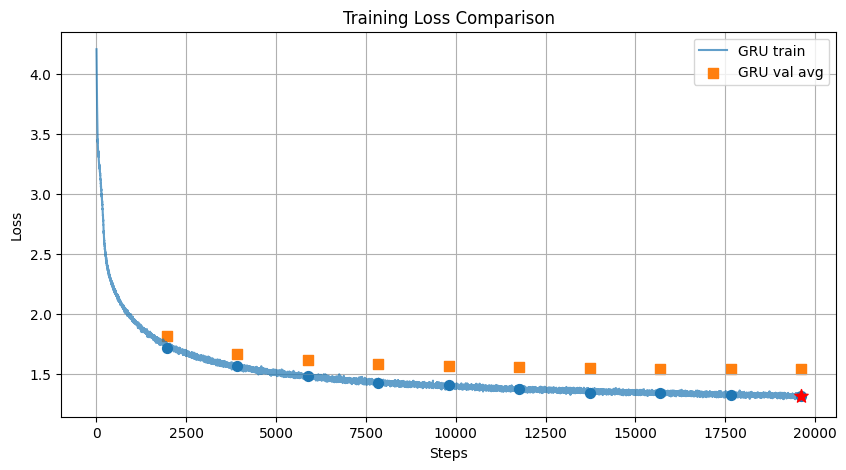

In [26]:
plot_loss_comparisons()

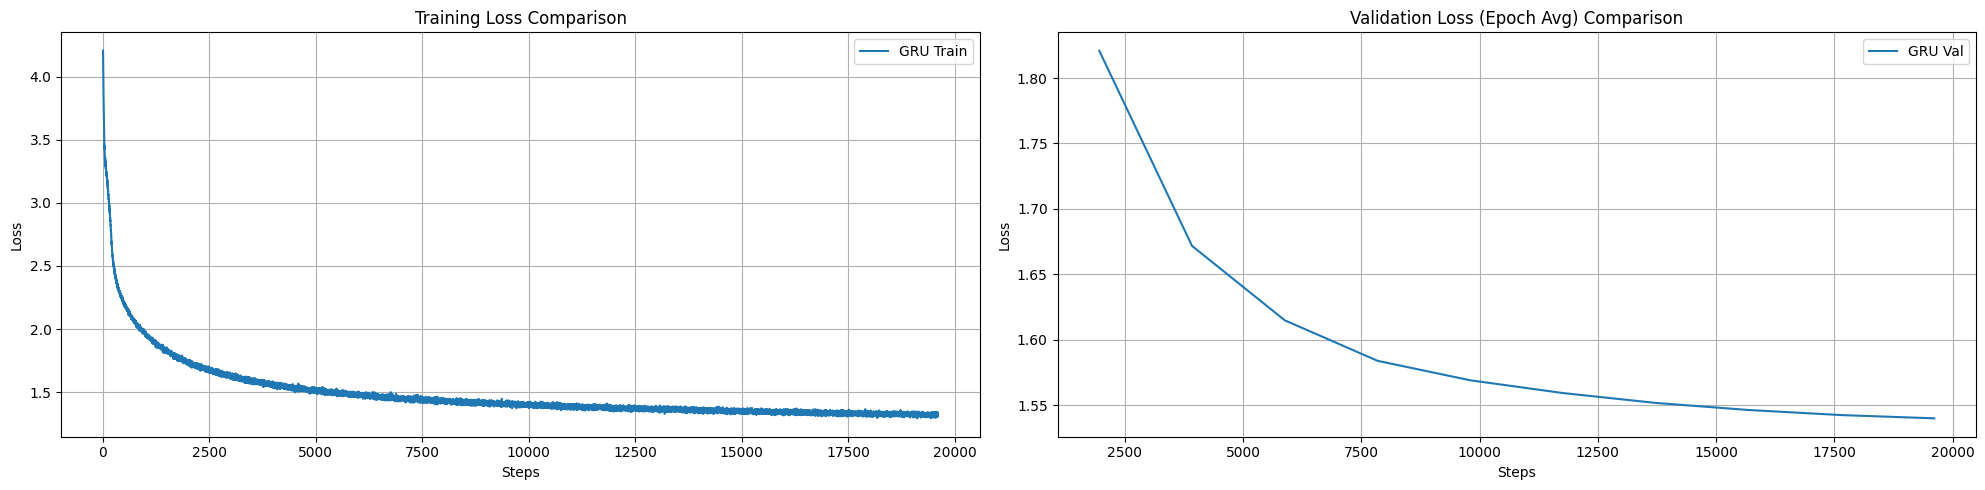

In [27]:
plot_separate_train_val(loss_comparison_dict)

In [28]:
def generate_text_attention(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text

    with torch.no_grad():
        for _ in range(max_length):
            # Convert the last sequence of characters to indices and feed it to the model
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output = model(x)[0]  # No hidden state needed for attention-based models
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [29]:
def train_and_test(model_desc, model, start_text):
    # Initialize the model
    model = model.to(device)
    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    
    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    # Generate text
    generated_text = generate_text_attention(trained_model, char_to_idx, idx_to_char, start_text, device)
    print(f"Generated text [{start_text}]:")
    print("-"*50)
    print(generated_text)
    
    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()
    
    plot_separate_train_val(loss_comparison_dict)

In [30]:
del gru
torch.cuda.empty_cache()

import gc
gc.collect

<function gc.collect(generation=2)>

## Model 2: Modern Transformer(LLaMA - 2023)

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass

@dataclass
class ModelArgs:
    DIM = EMBEDDING_DIM 
    FFN_DIM = FFN_DIM
    NUM_HEADS = NUM_HEADS 
    NUM_LAYERS = NUM_LAYERS

    NUM_KV_HEADS = NUM_HEADS 
    VOCAB_SIZE = vocab_size
    NORM_EPS = 1e-5 # LLaMA: 1e-5
    ROPE_THETA = 10000 # LLaMA: 10000

    MAX_BATCH_SIZE = BATCH_SIZE
    MAX_SEQ_LEN = SEQUENCE_LENGTH # depending on the DATASET
    NUM_KV_HEAD_REP = NUM_HEADS // NUM_KV_HEADS

    HEAD_DIM = DIM // NUM_HEADS
    DROPOUT = DROPOUT
    DEVICE = device

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def _norm(self, x: torch.Tensor):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
    def forward(self, x: torch.Tensor):
        return self.weight.to(x.device) * self._norm(x.float()).type_as(x)
    
def precompute_freqs_cis(head_dim: int, seq_len: int, theta: float = 100.0, device: str = "cuda"):
    if head_dim % 2 != 0:
        raise ValueError("head_dim must be even for rotary embeddings.")
    freqs = 1.0 / (theta ** (torch.arange(0, head_dim, 2).float() / head_dim)).to(device)
    t = torch.arange(seq_len, device=device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)  # [seq_len, head_dim//2]
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis  # [seq_len, head_dim // 2]

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    L = x.shape[1]
    return freqs_cis.view(1, L, 1, x.shape[-1] // 2)  # [1, L, 1, head_dim]

def apply_rotary_emb(x: torch.Tensor, device: str = "cuda"):
    # x: [B, L, 2*heads, D] & D is even
    _, L, _, D = x.shape
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2)) # [B, L, 2*heads, D//2, 2]
    freqs_cis = precompute_freqs_cis(D, L)
    freqs = reshape_for_broadcast(freqs_cis, x)
    x_rotated = x_complex * freqs
    x_out = torch.view_as_real(x_rotated).reshape(x.shape)
    return x_out.type_as(x).to(device)

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    B, L, nk, d = x.shape
    if n_rep == 1:
        return x
    return x[:, :, :, None, :].expand(B, L, nk, n_rep, d).reshape(B, L, nk * n_rep, d)

class FeedForward(nn.Module):
    def __init__(self, dim, ffn_dim, dropout):
        super().__init__()
        hidden_dim = ffn_dim
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, hidden_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x: torch.Tensor):
        # x: [B, L, D]
        return self.w2(F.silu(self.w1(x)) * self.dropout(self.w3(x)))

class SelfAttention(nn.Module):
    def __init__(self, n_heads, n_kv_heads, n_rep, dim, dropout, batch, seq_len, device):
        super().__init__()
        self.n_heads_q = n_heads
        self.n_kv_heads = n_kv_heads
        self.n_rep = n_rep
        self.head_dim = dim // n_heads

        self.wq = nn.Linear(dim, n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(dim, n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(dim, n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(n_heads * self.head_dim, dim, bias=False)
        self.attn_dropout = dropout
        
        self.norm = RMSNorm(self.head_dim)

    def forward(self, x: torch.Tensor, start_pos, mask, return_attn=False):
        B, L, _ = x.shape
        src_len = trg_len = L
        offset = start_pos
        
        xq = self.wq(x).view(B, L, self.n_heads_q, self.head_dim)
        xk = self.wk(x).view(B, L, self.n_kv_heads, self.head_dim)
        xv = self.wv(x).view(B, L, self.n_kv_heads, self.head_dim)
        
        # Apply rotary embeddings
        xq = apply_rotary_emb(xq)
        xk = apply_rotary_emb(xk)
        
        # GQA: Adjust dimensions for attention computation
        xq = xq.transpose(1, 2)   # [B, n_heads, L, head_dim]
        xk = repeat_kv(xk, self.n_rep).transpose(1, 2) # [B, n_heads, L, head_dim]
        xv = repeat_kv(xv, self.n_rep).transpose(1, 2) # [B, n_heads, L, head_dim]

        # Compute scaled dot-product attention manually to capture attention weights
        scores = torch.matmul(xq, xk.transpose(-2, -1)) / math.sqrt(self.head_dim)  # [B, n_heads, L, L]
        scores = torch.nan_to_num(scores)
        if mask is None:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(attn_weights),
                1 + offset,
            )
            
        scores += mask
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = F.dropout(attn_weights, self.attn_dropout, training=self.training)
        attn_output = torch.matmul(attn_weights, xv)  # [B, n_heads, L, head_dim]
        attn_output = self.norm(attn_output)
        
        # Reshape attention output and project
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, L, -1)
        output = self.wo(attn_output)  # [B, L, D]
        if return_attn:
            return output, attn_weights
        else:
            return output

class TransformerBlock(nn.Module):
    def __init__(self, args: 'ModelArgs'):
        super().__init__()
        self.attention = SelfAttention(
            args.NUM_HEADS, 
            args.NUM_KV_HEADS, 
            args.NUM_KV_HEAD_REP, 
            args.DIM, 
            args.DROPOUT, 
            args.MAX_BATCH_SIZE, 
            args.MAX_SEQ_LEN, 
            args.DEVICE
        )
        self.ffn = FeedForward(args.DIM, args.FFN_DIM, args.DROPOUT)
        self.attention_norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.ffn_norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.res_dropout = nn.Dropout(args.DROPOUT)
        
    def forward(self, x: torch.Tensor, start_pos, mask, return_attn=False):
        if return_attn:
            attn_out, attn_map = self.attention(self.attention_norm(x), start_pos, mask, return_attn=True)
            h = x + self.res_dropout(attn_out)
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h, attn_map
        else:
            h = x + self.res_dropout(self.attention(self.attention_norm(x), start_pos, mask))
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h

class LlamaTransformer(nn.Module):
    def __init__(self, args: 'ModelArgs'):
        super().__init__()
        self.args = args
        self.tok_embeddings = nn.Embedding(args.VOCAB_SIZE, args.DIM)
        self.layers = nn.ModuleList([TransformerBlock(args) for _ in range(args.NUM_LAYERS)])
        self.norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.output = nn.Linear(args.DIM, args.VOCAB_SIZE, bias=False)
        self.device = args.DEVICE
        
    def forward(self, x: torch.Tensor, start_pos=0, return_attn=False):
        B, L = x.shape
        h = self.tok_embeddings(x)  # [B, L, D]
        
        mask = None
        if L > 1:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(x),
                1 + start_pos,
            )
        attn_maps = []
        for layer in self.layers:
            if return_attn:
                h, attn_map = layer(h, start_pos, mask, return_attn=True)
                attn_maps.append(attn_map)
            else:
                h = layer(h, start_pos, mask)
        logits = self.output(self.norm(h)).float()
        if return_attn:
            return logits, attn_maps
        return logits, _

In [32]:
PARAMS = ModelArgs()
llama = LlamaTransformer(PARAMS).to(device)
llama

LlamaTransformer(
  (tok_embeddings): Embedding(65, 64)
  (layers): ModuleList(
    (0-3): 4 x TransformerBlock(
      (attention): SelfAttention(
        (wq): Linear(in_features=64, out_features=64, bias=False)
        (wk): Linear(in_features=64, out_features=64, bias=False)
        (wv): Linear(in_features=64, out_features=64, bias=False)
        (wo): Linear(in_features=64, out_features=64, bias=False)
        (norm): RMSNorm()
      )
      (ffn): FeedForward(
        (w1): Linear(in_features=64, out_features=480, bias=False)
        (w2): Linear(in_features=480, out_features=64, bias=False)
        (w3): Linear(in_features=64, out_features=480, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (res_dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=64, out_features=65, bias=False)
)

In [33]:
summary(llama.to(device), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
LlamaTransformer                         [512, 64, 65]             --
├─Embedding: 1-1                         [512, 64, 64]             4,160
├─ModuleList: 1-2                        --                        --
│    └─TransformerBlock: 2-1             [512, 64, 64]             --
│    │    └─RMSNorm: 3-1                 [512, 64, 64]             64
│    │    └─SelfAttention: 3-2           [512, 64, 64]             16,400
│    │    └─Dropout: 3-3                 [512, 64, 64]             --
│    │    └─RMSNorm: 3-4                 [512, 64, 64]             64
│    │    └─FeedForward: 3-5             [512, 64, 64]             92,160
│    │    └─Dropout: 3-6                 [512, 64, 64]             --
│    └─TransformerBlock: 2-2             [512, 64, 64]             --
│    │    └─RMSNorm: 3-7                 [512, 64, 64]             64
│    │    └─SelfAttention: 3-8           [512, 64, 64]             16,400


Epoch 1/10, Train Loss: 1.8043, Val Loss: 1.8764, Epoch Time: 58.21s Average Vram Usage: 43.90MB


Epoch 2/10, Train Loss: 1.6335, Val Loss: 1.7737, Epoch Time: 57.11s Average Vram Usage: 43.90MB


Epoch 3/10, Train Loss: 1.5628, Val Loss: 1.7544, Epoch Time: 57.34s Average Vram Usage: 43.90MB


Epoch 4/10, Train Loss: 1.5298, Val Loss: 1.7397, Epoch Time: 57.37s Average Vram Usage: 43.90MB


Epoch 5/10, Train Loss: 1.4985, Val Loss: 1.7263, Epoch Time: 58.32s Average Vram Usage: 43.90MB


Epoch 6/10, Train Loss: 1.4623, Val Loss: 1.7259, Epoch Time: 57.22s Average Vram Usage: 43.90MB


Epoch 7/10, Train Loss: 1.4480, Val Loss: 1.7251, Epoch Time: 56.57s Average Vram Usage: 43.90MB


Epoch 8/10, Train Loss: 1.4436, Val Loss: 1.7213, Epoch Time: 55.32s Average Vram Usage: 43.90MB


Epoch 9/10, Train Loss: 1.4123, Val Loss: 1.7171, Epoch Time: 55.62s Average Vram Usage: 43.90MB


Epoch 10/10, Train Loss: 1.4257, Val Loss: 1.7023, Epoch Time: 57.33s Average Vram Usage: 43.90MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow! 'Shall want thou kindness.

MONTAGUE:
O, the midnight, but thy love's peace.

GLOUCESTER:
Your can sludied, being too thee you see where.

NORTHUMBERLAND:
Mame how me: you shall you be at my joy of the reason of my since,
Even to use your compassions and to the house well;
Well you double man, and we would tosse yours,
Madam, ere you and hundrth in the rights,
For hath some noble lay fretter did spurpose
Of degented hasty lot me more: and I have meet
frownd, Aufidius heart thou art injoice
As


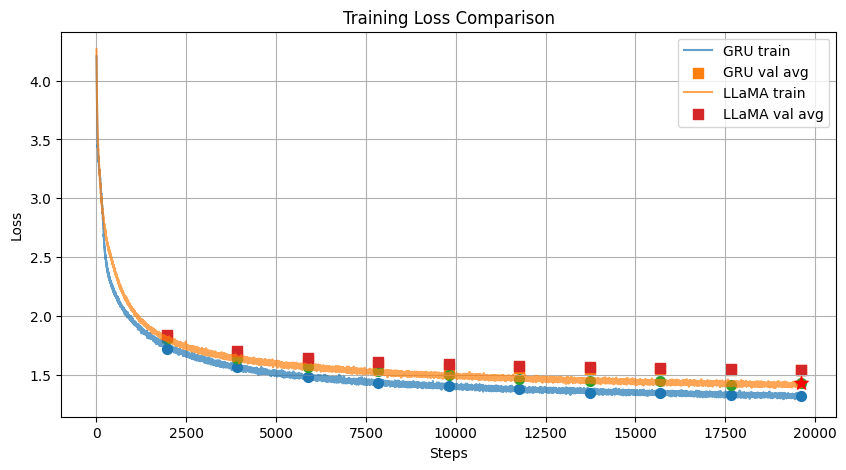

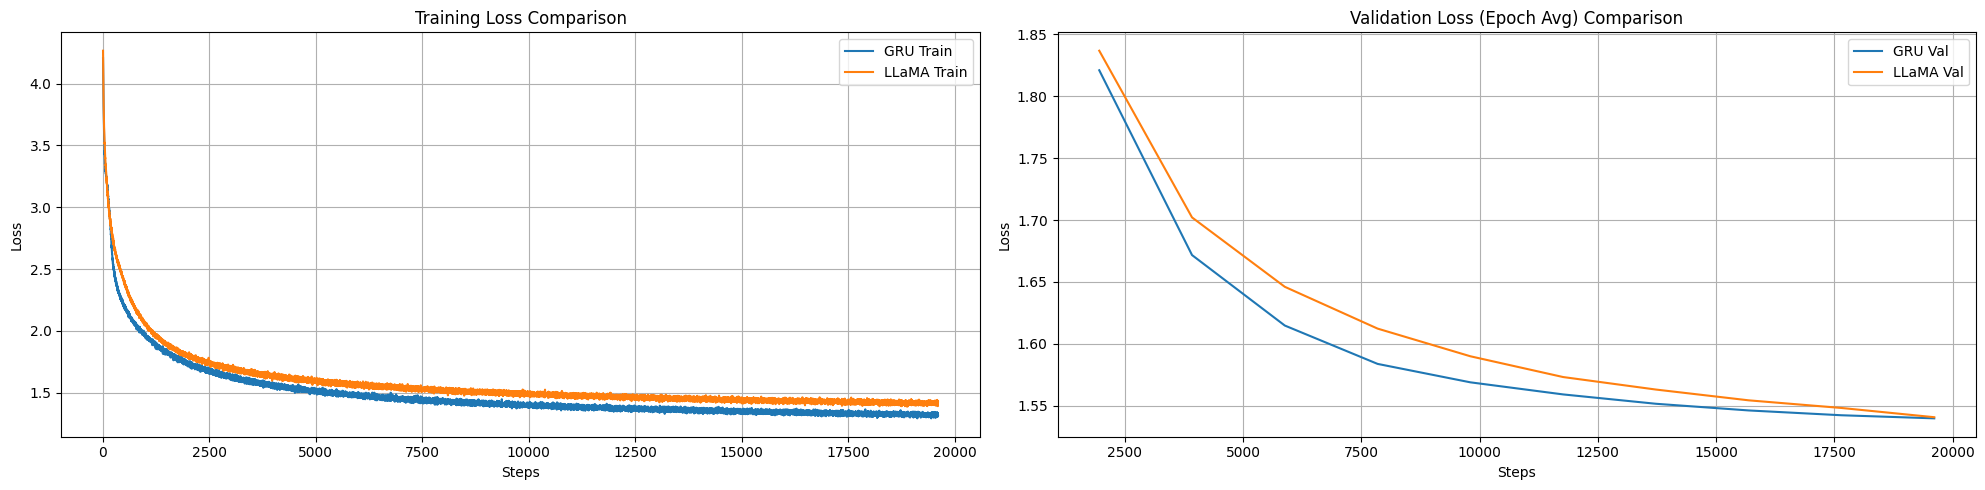

In [34]:
train_and_test("LLaMA", llama, start_text)

In [35]:
del llama
torch.cuda.empty_cache()
gc.collect

<function gc.collect(generation=2)>

## Model 3: Mamba

In [36]:
import torch
import torch.nn as nn

from torch.nn import functional as F
from einops import rearrange

In [37]:
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def _norm(self, x: torch.Tensor):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
    def forward(self, x: torch.Tensor):
        return self.weight.to(x.device) * self._norm(x.float()).type_as(x)


class SSM(nn.Module):
    def __init__(self, seq_len, d_model, state_size, device='cuda'):
        super(SSM, self).__init__()
        self.fc_delta = nn.Linear(d_model, d_model, device=device)
        self.fc_B = nn.Linear(d_model, state_size, device=device)
        self.fc_C = nn.Linear(d_model, state_size, device=device)
        self.seq_len = seq_len
        self.d_model = d_model
        self.state_size = state_size
        self.A = nn.Parameter(torch.empty(d_model, state_size, device=device))
        nn.init.xavier_uniform_(self.A)

    def discretization(self, delta, B):
        dB = torch.einsum("bld,bln->bldn", delta, B)
        dA = torch.exp(torch.clamp(torch.einsum("bld,dn->bldn", delta, self.A), max=10.0))
        return dA, dB

    def forward(self, x):
        B_val = self.fc_B(x)
        C = self.fc_C(x)
        delta = F.softplus(self.fc_delta(x))
        dA, dB = self.discretization(delta, B_val)
        # h는 0으로 초기화되므로 첫 항은 0; 결과적으로 x에 dB를 곱한 값만 사용됨
        h = torch.zeros(x.size(0), self.seq_len, self.d_model, self.state_size, device=x.device)
        h = torch.einsum('bldn,bldn->bldn', dA, h) + rearrange(x, "b l d -> b l d 1") * dB
        y = torch.einsum('bln,bldn->bld', C, h)
        return y

class MambaBlock(nn.Module):
    def __init__(self, seq_len, d_model, state_size, device):
        super(MambaBlock, self).__init__()
        self.inp_proj = nn.Linear(d_model, 2*d_model, device=device)
        self.out_proj = nn.Linear(2*d_model, d_model, device=device)
        # residual 연결을 위한 선형층
        self.D = nn.Linear(d_model, 2*d_model, device=device)
        # bias에 weight decay 적용 안 함
        self.out_proj.bias._no_weight_decay = True
        nn.init.constant_(self.out_proj.bias, 1.0)
        self.SSM = SSM(seq_len, 2*d_model, state_size, device)
        # 컨볼루션은 feature 차원(2*d_model)에 대해 적용
        # 기존의 symmetric padding 대신 인과적(causal) padding을 위해 padding=0으로 설정
        self.conv = nn.Conv1d(2*d_model, 2*d_model, kernel_size=3, padding=0, device=device)
        self.conv_linear = nn.Linear(2*d_model, 2*d_model, device=device)
        self.norm = RMSNorm(d_model)

    def forward(self, x):
        # 입력 정규화
        x = self.norm(x)
        x_proj = self.inp_proj(x)  # [B, L, 2*d_model]

        # 인과적 패딩 적용: 컨볼루션 시 현재 시점보다 미래 정보를 보지 않도록
        # (B, L, 2*d_model) -> (B, 2*d_model, L)
        x_proj_t = x_proj.transpose(1, 2)
        # kernel_size=3이면 왼쪽에 2개(padding=(kernel_size-1, 0)) 패딩 적용
        x_proj_t = F.pad(x_proj_t, (2, 0))
        # 컨볼루션 적용 후 다시 (B, L, 2*d_model)로 전치
        x_conv = self.conv(x_proj_t).transpose(1, 2)

        x_conv_act = F.silu(x_conv)
        x_conv_out = self.conv_linear(x_conv_act)
        x_ssm = self.SSM(x_conv_out)
        x_act = F.silu(x_ssm)

        x_residual = F.silu(self.D(x))
        # element-wise 곱을 통해 블록 출력을 생성
        x_combined = x_act * x_residual
        x_out = self.out_proj(x_combined)
        return x_out

# Mamba 모델 (정답 누수 방지를 위해 forward의 반환값 수정)
class Mamba(nn.Module):
    def __init__(self, seq_len, d_model, state_size, n_layers, vocab_size, device):
        super(Mamba, self).__init__()
        self.tok_embeddings = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([MambaBlock(seq_len, d_model, state_size, device) for _ in range(n_layers)])
        self.norm = RMSNorm(d_model)
        self.output = nn.Linear(d_model, vocab_size)
        self.seq_len = seq_len
        self.device = device

    def forward(self, x):
        # x: [B, L]
        h = self.tok_embeddings(x)  # [B, L, d_model]
        for layer in self.layers:
            h = layer(h)
        # 최종 정규화 후 vocabulary 차원으로 매핑
        logits = self.output(self.norm(h))
        # next token prediction을 위해, 현재 입력 시퀀스의 마지막 토큰은 정답 누수를 방지하기 위해 제외함
        # (예: 입력: [w1, w2, ..., w_N] -> 예측: [w2, ..., w_N]를 위해 마지막 출력 제거)
        return logits, None

In [38]:
STATE_SIZE = 8

x = torch.randint(0, vocab_size, (BATCH_SIZE, SEQUENCE_LENGTH)).to(device)
# Create the Mamba model
mamba = Mamba(SEQUENCE_LENGTH, EMBEDDING_DIM, STATE_SIZE, NUM_LAYERS, vocab_size, device).to(device)
# Forward pass
test_output, _ = mamba(x)
print(f"test_output.shape = {test_output.shape}") 

test_output.shape = torch.Size([512, 64, 65])


In [39]:
from torchinfo import summary

summary(mamba.to(device), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
Mamba                                    [512, 64, 65]             --
├─Embedding: 1-1                         [512, 64, 64]             4,160
├─ModuleList: 1-2                        --                        --
│    └─MambaBlock: 2-1                   [512, 64, 64]             --
│    │    └─RMSNorm: 3-1                 [512, 64, 64]             64
│    │    └─Linear: 3-2                  [512, 64, 128]            8,320
│    │    └─Conv1d: 3-3                  [512, 128, 64]            49,280
│    │    └─Linear: 3-4                  [512, 64, 128]            16,512
│    │    └─SSM: 3-5                     [512, 64, 128]            19,600
│    │    └─Linear: 3-6                  [512, 64, 128]            8,320
│    │    └─Linear: 3-7                  [512, 64, 64]             8,256
│    └─MambaBlock: 2-2                   [512, 64, 64]             --
│    │    └─RMSNorm: 3-8                 [512, 64, 64]       

Epoch 1/10, Train Loss: 2.2662, Val Loss: 2.2942, Epoch Time: 70.40s Average Vram Usage: 3446.34MB


Epoch 2/10, Train Loss: 1.5167, Val Loss: 1.8103, Epoch Time: 69.72s Average Vram Usage: 3446.34MB


Epoch 3/10, Train Loss: 1.4449, Val Loss: 1.8072, Epoch Time: 70.26s Average Vram Usage: 3446.34MB


Epoch 4/10, Train Loss: 1.3911, Val Loss: 1.7470, Epoch Time: 69.69s Average Vram Usage: 3446.34MB


Epoch 5/10, Train Loss: 1.3786, Val Loss: 1.7228, Epoch Time: 70.25s Average Vram Usage: 3446.34MB


Epoch 6/10, Train Loss: 1.3562, Val Loss: 1.7280, Epoch Time: 70.17s Average Vram Usage: 3446.34MB


Epoch 7/10, Train Loss: 1.3393, Val Loss: 1.7323, Epoch Time: 69.64s Average Vram Usage: 3446.34MB


Epoch 8/10, Train Loss: 1.3291, Val Loss: 1.7658, Epoch Time: 70.06s Average Vram Usage: 3446.34MB


Epoch 9/10, Train Loss: 1.3193, Val Loss: 1.7663, Epoch Time: 70.18s Average Vram Usage: 3446.34MB


Epoch 10/10, Train Loss: 1.2934, Val Loss: 1.7724, Epoch Time: 69.93s Average Vram Usage: 3446.34MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow:
An affection of thy wine else Angelo, o'er comfort of our lordship?

First Lord, or in this selfsame of this oath; and pledge my name, gentley, nor through live to grant this answer to see my Clarence to light about him patient and means:
I will have mid's royal, dear Tybalt, I am ease
with hap
When to him wheel you now was but with the looks
Upon your desperate of his brother;
And yet o' the great Edward forced and then present bodgeth attend of lip, some nothingrother took the sickness
'Twe


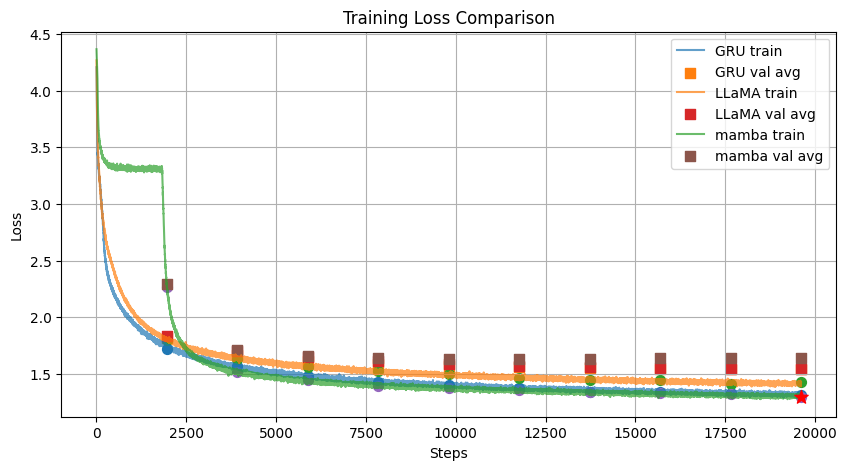

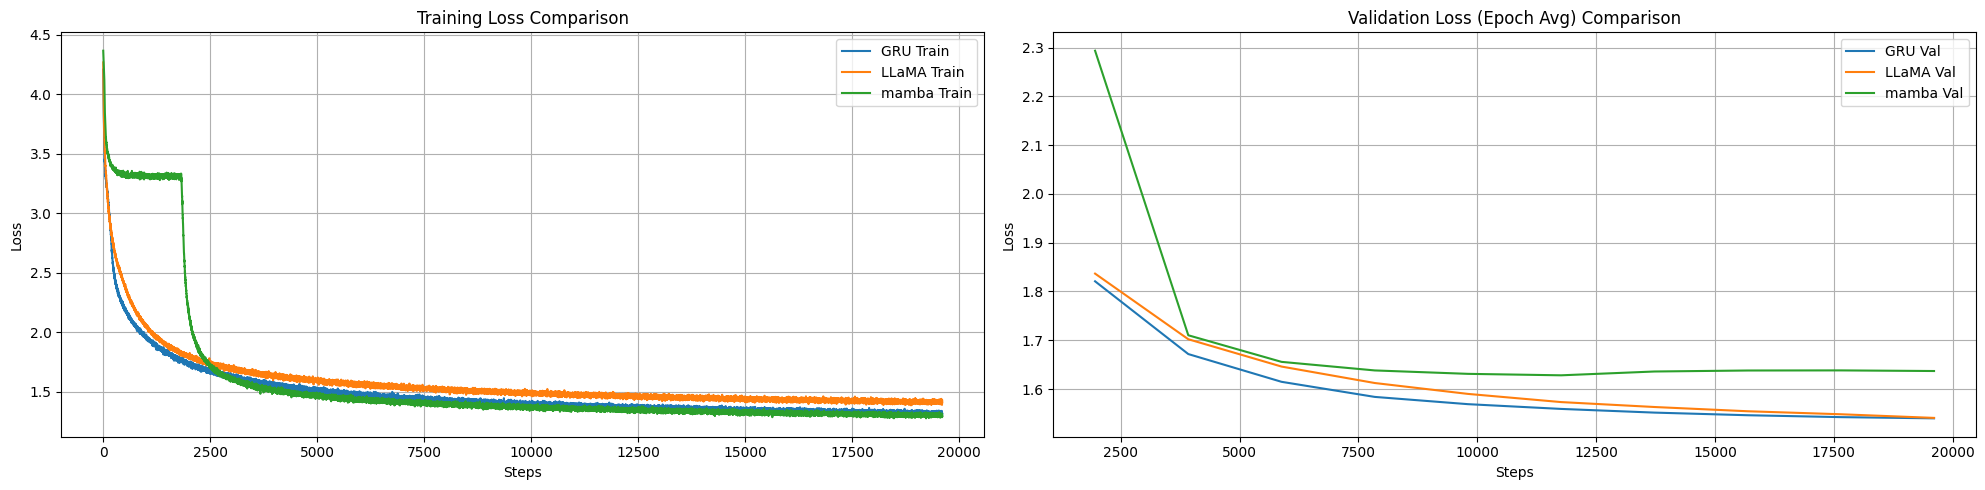

In [40]:
train_and_test("mamba", mamba, start_text)